In [330]:
import numpy as np
import math as m
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
#import pymc

## Problem 1

In [331]:
def T22(x,phi,h):
    a    = 0.95
    b    = 0.95
    k    = 2.37
    L    = 70
    Tamb = 21.29
    gamma = np.sqrt(2*(a+b)*h/(a*b*k))
    c1_1  = -1*phi/(k*gamma)
    ep = m.e**(gamma*L)*(h+k*gamma)
    en = m.e**(-1*gamma*L)*(h-k*gamma)
    c1_2 = ep/(en+ep)
    c1 = c1_1*c1_2
    c2 = (phi/(k*gamma))+c1
    return (c1*m.e**(-1*gamma*x)+c2*m.e**(gamma*x)+Tamb)

In [332]:
from scipy import optimize
x    = np.array([10,14,18,22,26,30,34,38,42,46,50,54,58,62,66])
temp = np.array([96.14,80.12,67.66,57.96,50.90,44.84,39.75,36.16,33.31,31.15,29.28,27.88,27.18,26.40,25.86])

popt, pcov = optimize.curve_fit(T22, x, temp, p0 = [10,.00191])#, bounds=(0, [3., 1., 0.5]))

popt

array([-1.84148511e+01,  1.91432142e-03])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


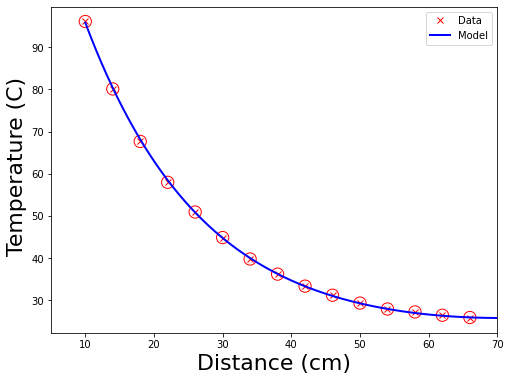

In [333]:
plt.figure(figsize=(8,6))
plt.plot(x,temp,'rx',label='Data')
plt.scatter(x, temp, s=150, facecolors='none', edgecolors='r')
x1 = np.linspace(10,70,1000)
plt.plot(x1,T22(x1,-18.41 , .00191),'b',linewidth=2,label='Model')
plt.xlabel("Distance (cm)", fontsize = 22)
plt.ylabel(" Temperature (C)", fontsize = 22)
plt.legend()
plt.xlim(5,70)
plt.savefig("P1_fit.eps")

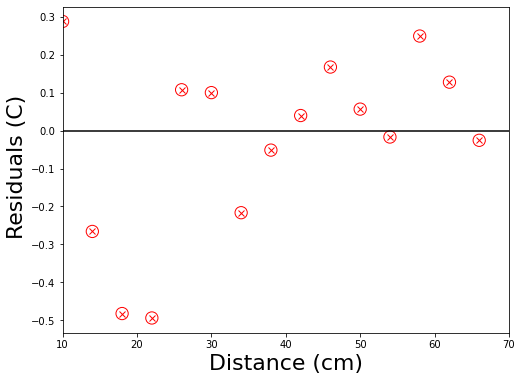

In [334]:
plt.figure(figsize=(8,6))
xb = np.linspace(0,70,1000)
Res = -1*(temp-T22(x,-18.41 , .00191))
plt.plot(x,-1*Res,'rx')
plt.scatter(x, -1*Res, s=150, facecolors='none', edgecolors='r')
plt.plot(xb,np.zeros(np.size(xb)),'k')
plt.xlabel("Distance (cm)", fontsize = 22)
plt.ylabel(" Residuals (C)", fontsize = 22)
plt.xlim([10,70])
plt.savefig("P1_res.eps")

In [335]:
pcov

array([[ 1.93898622e-02, -1.87350573e-06],
       [-1.87350573e-06,  1.94041152e-10]])

In [336]:
def T22(x,phi,h):
    a    = 0.95
    b    = 0.95
    k    = 2.37
    L    = 70
    Tamb = 21.29
    gamma = np.sqrt(2*(a+b)*h/(a*b*k))
    c1_1  = -1*phi/(k*gamma)
    ep = m.e**(gamma*L)*(h+k*gamma)
    en = m.e**(-1*gamma*L)*(h-k*gamma)
    c1_2 = ep/(en+ep)
    c1 = c1_1*c1_2
    c2 = (phi/(k*gamma))+c1
    return (c1*m.e**(-1*gamma*x)+c2*m.e**(gamma*x)+Tamb)

In [337]:
x      = np.array([10,14,18,22,26,30,34,38,42,46,50,54,58,62,66])
temp   = np.array([96.14,80.12,67.66,57.96,50.90,44.84,39.75,36.16,33.31,31.15,29.28,27.88,27.18,26.40,25.86])

q0     = [popt[0],popt[1]]
SS_q0  = np.sum((temp-T22(x,q0[0],q0[1]))**2)
s0     = SS_q0/(15-2)
V0     = pcov
R0     = np.linalg.cholesky(V0)

# DRAM Loop starts here

In [340]:
def alpha(ssq1,ssq2,s):
    temp = min(1,m.exp(-(ssq1-ssq2)/(2*s)))
    return(temp)

def J(q,s):
    # Isotropic likelihood fxn
    temp = np.random.normal(q,s)
    return(temp)

def Pi(ssq,sigma_sq):
    temp = m.exp(-1*ssq/(2*sigma_sq))
    return(temp)

def kde(xd,x_grid):
    kde = stats.kde.gaussian_kde(xd)
    return kde.evaluate(x_grid)

In [341]:
k0 = 100
Q0 = []
Q1 = []

import builtins
range = builtins.range
SS_qk1 = SS_q0
qk1    = q0
Rk1     = R0
Vk1     = V0
for t in range (0,100000):
    zk_p  = np.random.normal(0,np.eye(2))
    zk    = zk_p[0,:]+zk_p[1,:]
    q_str = qk1+np.matmul(Rk1,zk)
    u_alpha = np.random.uniform(low=0.0, high=1.0, size=None)
    SS_qstr  = np.sum((temp-T22(x,q_str[0],q_str[1]))**2)
    s2_k1   = SS_qk1/(15-2)
    #alpha_str = min(1,m.exp(-(SS_qstr-SS_q0)/(2*s2_k1)))
    alpha_str = alpha(SS_qstr,SS_q0,s2_k1)
    if (u_alpha < alpha_str):
        qk    = q_str
        SS_qk = SS_qstr
        Q0.append(qk[0]) 
        Q1.append(qk[1])
        qk1 = qk
    else:
        # DR Call
        gamma2 = 1/5
        zkDR_p  = np.random.normal(0,np.eye(2))
        zkDR    = zkDR_p[0,:]+zkDR_p[1,:]
        q2      = qk1+gamma2*np.matmul(Rk,zkDR)
        u2      = np.random.uniform(low=0.0, high=1.0, size=None)
        SSq2    = np.sum((temp-T22(x,q2[0],q2[1]))**2)
        alpha2  = min(1,Pi(SSq2,s2_k1)*(1-alpha(SS_qstr,SSq2,s2_k1))/(Pi(SS_qk1,s2_k1)*(1-alpha(SSq2,SS_qk1,s2_k1))))
        if (u2<alpha2):
            qk   = q2
            SS_qk = SSq2
            Q0.append(qk[0]) 
            Q1.append(qk[1])
            qk1 = qk
        else:
            qk   = qk1
            SS_qk = SS_qk1
            Q0.append(qk[0]) 
            Q1.append(qk[1])
            qk1 = qk
    if ((t%k0) == 1):
        B = np.zeros((2,k0))
        #print(np.shape(Q0))
        #B[0,:] = Q0
       # B[1,:] = Q1
    
        

In [350]:
xp1 = -19.5; xp2 = -17.5
xp = np.linspace(xp1,xp2,1000)
xh1 = 1.8E-3; xh2 = 2.0E-3
xh = np.linspace(xh1,xh2,1000)
pdfp = kde(Q0,xp)
pdfh = kde(Q1,xh)


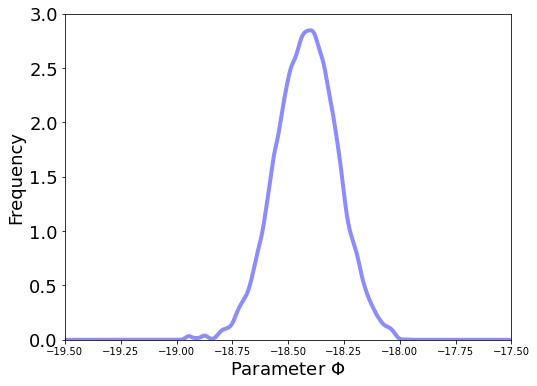

In [414]:
plt.figure(figsize=(8,6))
plt.plot(xp,pdfp,'b',linewidth=4,alpha=0.45)
plt.xlim(xp1,xp2)
plt.ylim(0,3)
plt.ylabel('Frequency',size=18)
plt.xlabel('Parameter $\Phi$',size=18)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=18)
plt.savefig('Margnial_Phi.png')

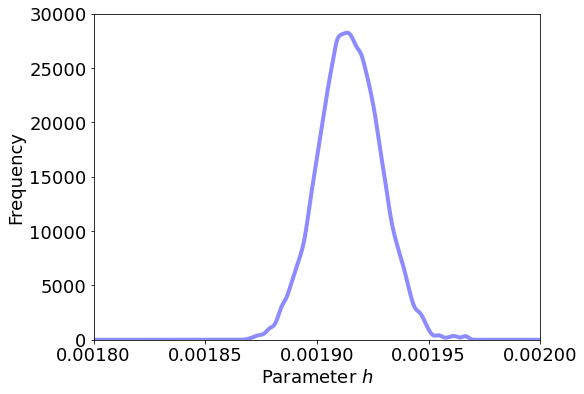

In [412]:
plt.figure(figsize=(8,6))
plt.plot(xh,pdfh,'b',linewidth=4,alpha=0.45)
plt.xlabel('Parameter $h$',size=18)
plt.ylabel('Frequency',size=18)
plt.xlim(xh1,xh2)
plt.ylim(0,3E4)
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
plt.savefig('Margnial_h.png')

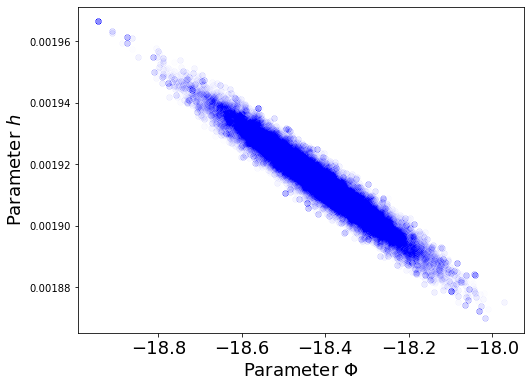

In [546]:
plt.figure(figsize=(8,6))
plt.plot(Q0,Q1,'bo',alpha=0.0051)
plt.ylabel('Parameter $h $',size=18)
plt.xlabel('Parameter $\Phi$',size=18)

plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=10)
plt.savefig('Phi_h.png')

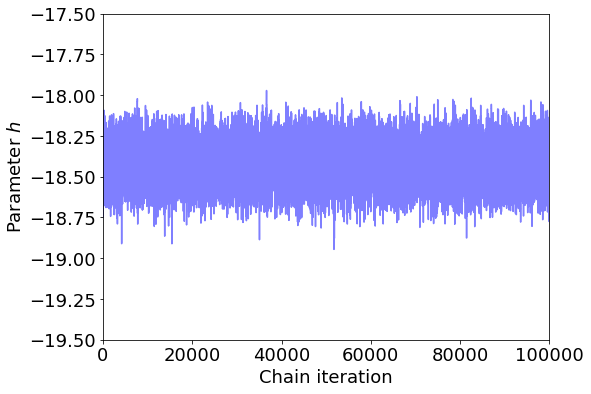

In [416]:
plt.figure(figsize=(8,6))
plt.plot(Q0,'b',alpha=0.5)
plt.xlim(0,100000)
plt.ylim(xp1,xp2)
plt.ylabel('Parameter $h$',size=18)
plt.xlabel('Chain iteration',size=18)
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
plt.savefig('Trace_h.png')

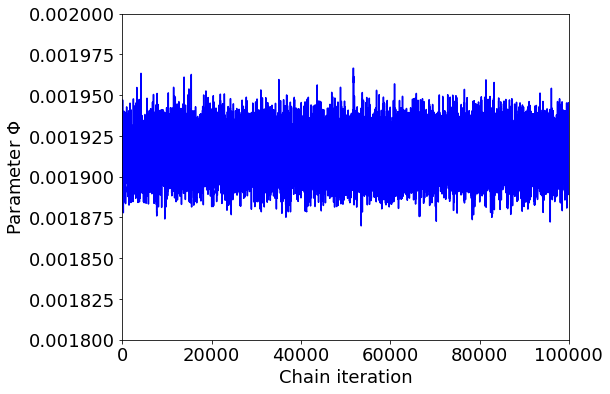

In [478]:
plt.figure(figsize=(8,6))
plt.plot(Q1,'b')
plt.xlim(0,100000)
plt.ylabel('Parameter $\Phi$',size=18)
plt.xlabel('Chain iteration',size=18)
plt.ylim(xh1,xh2)
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
plt.savefig('Trace_Phi.eps')

In [543]:
from scipy import integrate

def denom(Phi,h):
    X = np.array([10,14,18,22,26,30,34,38,42,46,50,54,58,62,66])
    V = np.array([96.14,80.12,67.66,57.96,50.90,44.84,39.75,36.16,33.31,31.15,29.28,27.88,27.18,26.40,25.86])
    ssq = np.sum((V-T22(X,Phi,h))**2)
    sigma0 = s0
    temp = m.exp(-ssq/(2*sigma0))
    return(temp)
    

    
def denom2(h,Phi):
    X = np.array([10,14,18,22,26,30,34,38,42,46,50,54,58,62,66])
    V = np.array([96.14,80.12,67.66,57.96,50.90,44.84,39.75,36.16,33.31,31.15,29.28,27.88,27.18,26.40,25.86])
    ssq = np.sum((V-T22(X,Phi,h))**2)
    sigma0 = s0
    temp = m.exp(-ssq/(2*sigma0))
    return(temp)
    
D,e = integrate.nquad(denom, [[-19,-18],[1.85E-3,1.95E-3]], args= None,
                opts=None) 

# Marginal PDF over Phi

Prange = np.linspace (xh1,xh2,80)
Marg_pdf_H = np.zeros(np.size(Prange))
for i in range (0,79):
    Pref =  Prange[i]
    Marg_pdf_H[i],es =  integrate.quad(denom, -17,-19, args=(Pref))


Hrange = np.linspace (xp1,xp2,80)
Marg_pdf_Phi = np.zeros(np.size(Hrange))
for i in range (0,79):
    Href =  Hrange[i]
    Marg_pdf_Phi[i],es =  integrate.quad(denom2, 1.8e-3,2E-3, args=(Href))

        

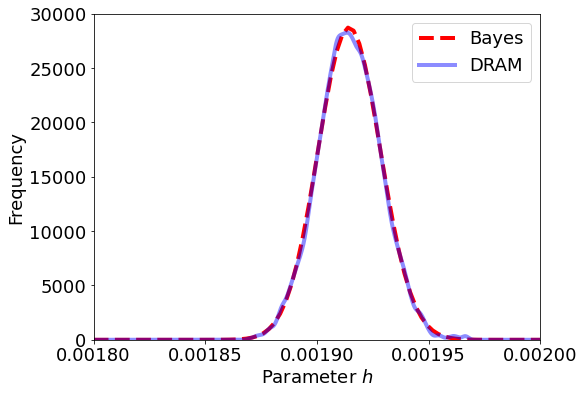

In [562]:
plt.figure(figsize=(8,6))
plt.plot(Prange,-1*Marg_pdf_H/D,'r--',linewidth=4,label='Bayes')
plt.plot(xh,pdfh,'b',linewidth=4,alpha=0.45,label='DRAM')
plt.xlabel('Parameter $h $',size=18)
plt.ylabel('Frequency',size=18)
plt.xlim(xh1,xh2)
plt.ylim(0,3E4)
plt.tick_params(axis="x", labelsize=18)
plt.tick_params(axis="y", labelsize=18)
plt.legend(fontsize=18)
plt.savefig('Margnial_h.png')

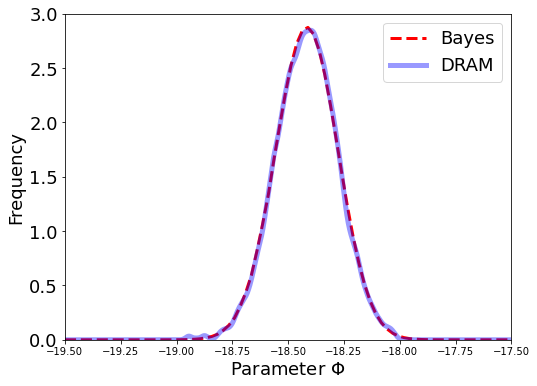

In [563]:
plt.figure(figsize=(8,6))
plt.plot(Hrange,Marg_pdf_Phi/D,'r--',linewidth=3,label='Bayes')
plt.plot(xp,pdfp,'b',linewidth=5,alpha=0.40,label='DRAM')
plt.xlim(xp1,xp2)
plt.ylim(0,3)
plt.ylabel('Frequency',size=18)
plt.xlabel('Parameter $\Phi$',size=18)
plt.tick_params(axis="x", labelsize=10)
plt.tick_params(axis="y", labelsize=18)
plt.legend(fontsize=18)
plt.savefig('Margnial_Phi.png')

In [566]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

In [570]:
def animate(i):
    graph_data = open('example.txt','r').read()
    lines = graph_data.split('\n')
    xs = []
    ys = []
    for line in lines:
        if len(line) > 1:
            x, y = line.split(',')
            xs.append(float(x))
            ys.append(float(y))
    ax1.clear()
    ax1.plot(xs, ys)

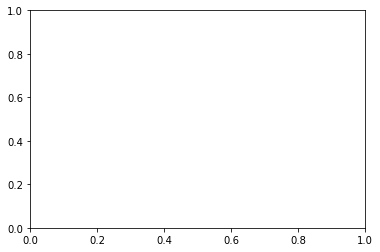

In [571]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()